## Importamos las librerías necesarias

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

import datetime

## Cargamos la información para los modelos

In [20]:
model_d = pd.read_csv('/home/jos/Downloads/PrecioRecomendado_sep/outputsPrecRec/baseForMod53_r.csv')
model_d = model_d[model_d['flagNA']==False]
model_d.date=pd.to_datetime(model_d.date)

In [40]:
model_d = pd.read_csv('/home/jos/Desktop/data.csv')

model_d.date=pd.to_datetime(model_d.date)

In [21]:
model_df = model_d[['regularVenta','flagNA','precioRegular','date'
                    ,'regular_2','regular_3','regular_4','regular_5','regular_6','regular_7','regular_8'
                   ,'regular_9','regular_10','regularTAR']]

In [41]:
model_df = model_d[['regMmas1','date','regM','value','CloseWTI']]

In [22]:
model_df = model_df.rename(columns = {'regularVenta':'sales'})

In [42]:
model_df = model_df.rename(columns = {'regMmas1':'sales'})

In [43]:
model_df

,sales,date,regM,value,CloseWTI
0,17.687000,2021-01-06,17.531000,19.6538,50.63
1,17.531000,2021-01-07,18.043302,20.0204,50.83
2,18.043302,2021-01-08,18.100479,20.0042,52.24
3,18.100479,2021-01-11,18.281358,20.0629,52.25
4,18.281358,2021-01-12,18.751250,19.7932,53.21
...,...,...,...,...,...
205,14.514018,2021-11-11,14.783358,20.6620,81.59
206,14.783358,2021-11-12,14.440566,20.5205,80.79
207,15.209066,2021-11-15,16.138192,20.6232,80.88
208,16.138192,2021-11-17,16.126626,20.6438,78.36


## Separamos los datos en parte de entrenamiento y parte para pruebas (80% y 20% respectivamente)

In [44]:
def tts(data):
    data = data.drop(['date'],axis=1)
    train, test = data[0:-54].values, data[-54:].values
    
    return train, test

train, test = tts(model_df)

## Creamos función para transformar los datos para que tomen valores entre -1 y 1
### Esto es para mejorar el rendimiento de algunos modelos y necesario para la red neuronal LSTM
Usamos la transformación MixMaxScaler que le resta a los valores el mínimo y lo divide entre el máximo.

In [45]:
def scale_data(train_set, test_set):
    #Aplicamos la transformación MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Pasamos los datos de entrenamiento al formato requerido para los modelos
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Pasamos los datos de prueba al formato requerido
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

## Creamos función para aplicar una transformación inversa a la que se hizo una vez que ya se finalizó el entrenamiento de los modelos

In [46]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #volvemos a construir datos de prueba para la transformación inversa
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #pasamos a las dimensiones adecuadas la tabla de predicciones de prueba
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #transformación inversa
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

## Función para cargar los datos para el modelo con las variables seleccionadas

In [44]:
def load_original_df():
    #Cargamos dataframe original sin la transformación aplicada
    original_df = pd.read_csv('/home/jos/Downloads/PrecioRecomendado_sep/outputsPrecRec/baseForMod53_r.csv')
    original_df = original_df[original_df['flagNA']==False]
    original_df = original_df[['regularVenta','precioRegular','date'
                    ,'regular_2','regular_3','regular_4','regular_5','regular_6','regular_7','regular_8'
                   ,'regular_9','regular_10','regularTAR']]
    original_df = original_df.rename(columns = {'regularVenta':'sales'})
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [47]:
def load_original_df():
    #Cargamos dataframe original sin la transformación aplicada
    original_df = pd.read_csv('/home/jos/Desktop/data.csv')
    original_df = original_df[['regMmas1','date','regM','value','CloseWTI']]
    original_df = original_df.rename(columns = {'regMmas1':'sales'})
    model_d.date=pd.to_datetime(model_d.date)
    return original_df

## Creamos tabla que muestra predicciones de ventas para los últimos 54 días

In [48]:
def predict_df(unscaled_predictions, original_df):
    #construimos tabla que muestra las predicciones de ventas
    result_list = []
    sales_dates = list(original_df[-55:].date)
    act_sales = list(original_df[-55:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0])
        result_dict['date'] = sales_dates[index]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

## Creamos función que muestra el error de media cuadrada, el error absoluto medio y la R cuadrada para los modelos

In [49]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-54:], unscaled_df.pred_value[-54:]))
    mae = mean_absolute_error(original_df.sales[-54:], unscaled_df.pred_value[-54:])
    r2 = r2_score(original_df.sales[-54:], unscaled_df.pred_value[-54:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

## Creamos función para graficar las ventas actuales contra las predicciones de ventas

In [50]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicciones', color='Red')
    
    ax.set(xlabel = "Fecha",
           ylabel = "Ventas",
           title = f"Forecast de ventas:{model_name} ")
    
    ax.legend()
    
    sns.despine()
    
 

## Creamos función para juntar las funciones anteriores para entrenar los modelos y mostrar resultados

In [51]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)
    

RMSE: 0.5776058983216074
MAE: 0.47895911111111117
R2 Score: 0.5789581905388457


/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


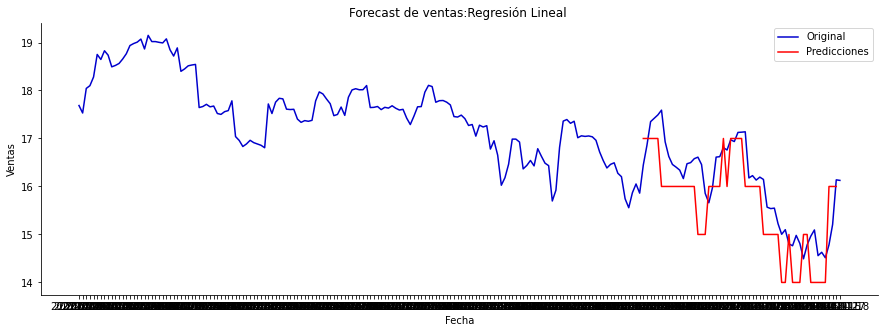

In [52]:
run_model(train, test, LinearRegression(), 'Regresión Lineal')

RMSE: 0.5812504621089232
MAE: 0.4649225185185182
R2 Score: 0.5736280685470996


/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


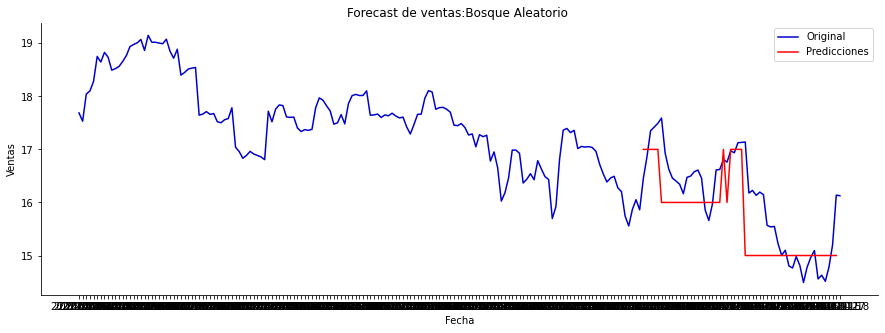

In [53]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'Bosque Aleatorio')

RMSE: 0.6254749037790344
MAE: 0.4834410370370367
R2 Score: 0.5062788152446097


/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


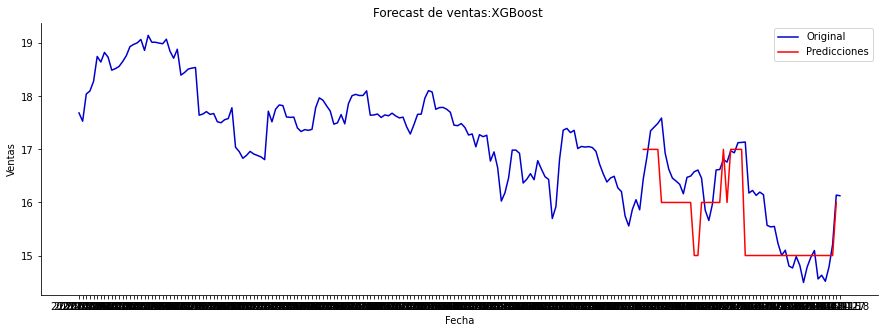

In [54]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

## Creamos la función para la red neuronal

In [55]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
156/156 [==============================] - 1s 731us/step - loss: 0.1546
Epoch 2/200
156/156 [==============================] - 0s 724us/step - loss: 0.0923
Epoch 3/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0593
Epoch 4/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0415
Epoch 5/200
156/156 [==============================] - 0s 763us/step - loss: 0.0310
Epoch 6/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0256
Epoch 7/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 8/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 9/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 10/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 11/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 12/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 1

156/156 [==============================] - 0s 714us/step - loss: 0.0044
Epoch 100/200
156/156 [==============================] - 0s 700us/step - loss: 0.0044
Epoch 101/200
156/156 [==============================] - 0s 702us/step - loss: 0.0044
Epoch 102/200
156/156 [==============================] - 0s 705us/step - loss: 0.0044
Epoch 103/200
156/156 [==============================] - 0s 908us/step - loss: 0.0044
Epoch 104/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 105/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 106/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 107/200
156/156 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 108/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 109/200
156/156 [==============================] - 0s 836us/step - loss: 0.0044
Epoch 110/200
156/156 [==============================] - 0s 916us/step - loss:

156/156 [==============================] - 0s 775us/step - loss: 0.0043
Epoch 196/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 197/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 198/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 199/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 200/200
156/156 [==============================] - 0s 1ms/step - loss: 0.0043
RMSE: 0.7321625576420498
MAE: 0.6515169777777777
R2 Score: 0.3234856461435226


/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jos/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


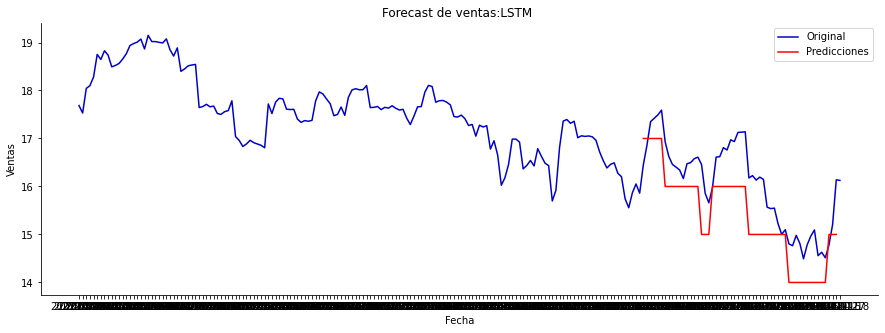

In [56]:
lstm_model(train, test)